In [1]:
import os

dict_path = os.environ["DATA"] + "/00_datasets/13.01_bis_time_MM_QM_dict_filtered_datasets.json"

# dict_path = os.environ["DATA"] + "/00_datasets/11.01_bis_test_time_MM_QM_dict.json"

fig_path = os.environ["FIGURES"] + "/00_datasets/13.01_times_MM_QM.png"
fig_path_size = os.environ["FIGURES"] + "/00_datasets/13.01_size_at_electrons.png"

In [2]:
import json

def load_dict(path):
    with open(path, "r") as f:
        return json.load(f)
    



In [3]:
d = load_dict(dict_path)

In [4]:
keys = ["RDKIT MMFF94", "OBABEL MMFF94", "DFT 3-21G*"]#, "DFT 6-31G(2df,p)"]

In [10]:
import pandas as pd
import numpy as np
from rdkit.Chem.Lipinski import HeavyAtomCount
from rdkit.Chem import MolFromSmiles

def create_tab_extract_data(d, keys):
    
    array_dict = {k: [] for k in ["dataset"] + keys}
    
    # Pour plot points time versus size avec différenciation CNOF/all
    all_success_smiles_CNOF = {k: [] for k in keys}
    all_success_smiles_all = {k: [] for k in keys}
    all_success_times_CNOF = {k: [] for k in keys}
    all_success_times_all = {k: [] for k in keys}
    
    # Pour plot grille distributions avec différenciation succès/échec
    success_times = {k: {k2: None for k2 in keys} for k in d.keys()}
    failure_times = {k: {k2: None for k2 in keys} for k in d.keys()}
    
    
    for exp_key in d.keys():
        
        if exp_key != "('ChEMBL', True, inf)" and exp_key != "('ChEMBL', False, inf)":

            array_dict["dataset"].append(exp_key)

            print(exp_key)


            for k in keys:
            

                # Extracting data
                curr_n_errors = len(d[exp_key][k+ " (errors)"]) 
                curr_n_success = len(d[exp_key][k])
                curr_n_total = curr_n_errors + curr_n_success
                curr_times_success = d[exp_key][k]
                curr_smiles_success = d[exp_key][k + " smiles"]
                curr_times_errors = d[exp_key][k+ " (errors)"]

                mean_time_success = np.mean(curr_times_success) if len(curr_times_success) > 0 else np.nan

                # Writing array value
                array_dict[k].append("{:.2f}".format(mean_time_success) + " (" + str(curr_n_success) + "/" + str(curr_n_total) + ") " + "{:.2f}".format(np.mean([HeavyAtomCount(MolFromSmiles(smi)) for smi in curr_smiles_success])))

                # Extracting whether CNOF or all atoms
                is_CNOF = "True" in exp_key

                # Writing times/molecules data
                if is_CNOF:
                    all_success_smiles_CNOF[k].extend(curr_smiles_success)
                    all_success_times_CNOF[k].extend(curr_times_success)
                else:
                    all_success_smiles_all[k].extend(curr_smiles_success)
                    all_success_times_all[k].extend(curr_times_success)

                # Writing times depending on success and experiment
                success_times[exp_key][k] = curr_times_success
                failure_times[exp_key][k] = curr_times_errors
    df = pd.DataFrame.from_dict(array_dict)
    return df, all_success_smiles_CNOF, all_success_times_CNOF, all_success_smiles_all, all_success_times_all, success_times, failure_times

In [11]:
df, all_success_smiles_CNOF, all_success_times_CNOF, all_success_smiles_all, \
    all_success_times_all, success_times, failure_times = create_tab_extract_data(d, keys)

('QM9', True, 9)
('ChEMBL', True, 9)
('ChEMBL', True, 30)


In [12]:
df

dataset           RDKIT MMFF94          OBABEL MMFF94  \
0      ('QM9', True, 9)   0.06 (820/1000) 8.80   0.18 (804/1000) 8.79   
1   ('ChEMBL', True, 9)   0.06 (906/1000) 7.72   0.15 (814/1000) 7.67   
2  ('ChEMBL', True, 30)  0.15 (887/1000) 23.51  0.30 (458/1000) 22.62   

             DFT 3-21G*  
0  238.18 (77/100) 8.81  
1  159.60 (86/100) 7.57  
2  3740.65 (5/10) 25.20

In [13]:
import seaborn as sns
sns.set(style="ticks", color_codes=True)
import matplotlib.pyplot as plt


def plot_distributions(success_times, failure_times):
    
    print(success_times.keys())
    
    fig, axs= plt.subplots(len(success_times.keys()), len(keys), sharex=True, #sharey=True,
                         figsize=(13, 17))
        
    for i, exp_key in enumerate(success_times.keys()):
        for j, k in enumerate(keys):
#             print(exp_key)
#             print(k)
            
            curr_ax = axs[i][j]
            curr_ax.set_xscale("log")
            curr_ax.set_xlim((1e-3, 1e8))
            
            if j == 0:
                curr_ax.set_ylabel(exp_key)
                
            if i == 0:
                curr_ax.set_title(k)
            
            
            curr_data_dict = {
                "value": success_times[exp_key][k] + failure_times[exp_key][k],
                "exp": ["succès" for m in range(len(success_times[exp_key][k]))] + ["échec" for m in range(len(failure_times[exp_key][k]))]
            }
            
            
            n_bins = 50
            
            curr_ax.hist(success_times[exp_key][k], color=sns.color_palette()[0], 
                         bins=np.logspace(-3, 8, n_bins))
            curr_ax.hist(failure_times[exp_key][k], color=sns.color_palette()[3], 
                         bins=np.logspace(-3, 8, n_bins))


dict_keys(["('QM9', True, 9)", "('ChEMBL', True, 9)", "('ChEMBL', True, 30)"])


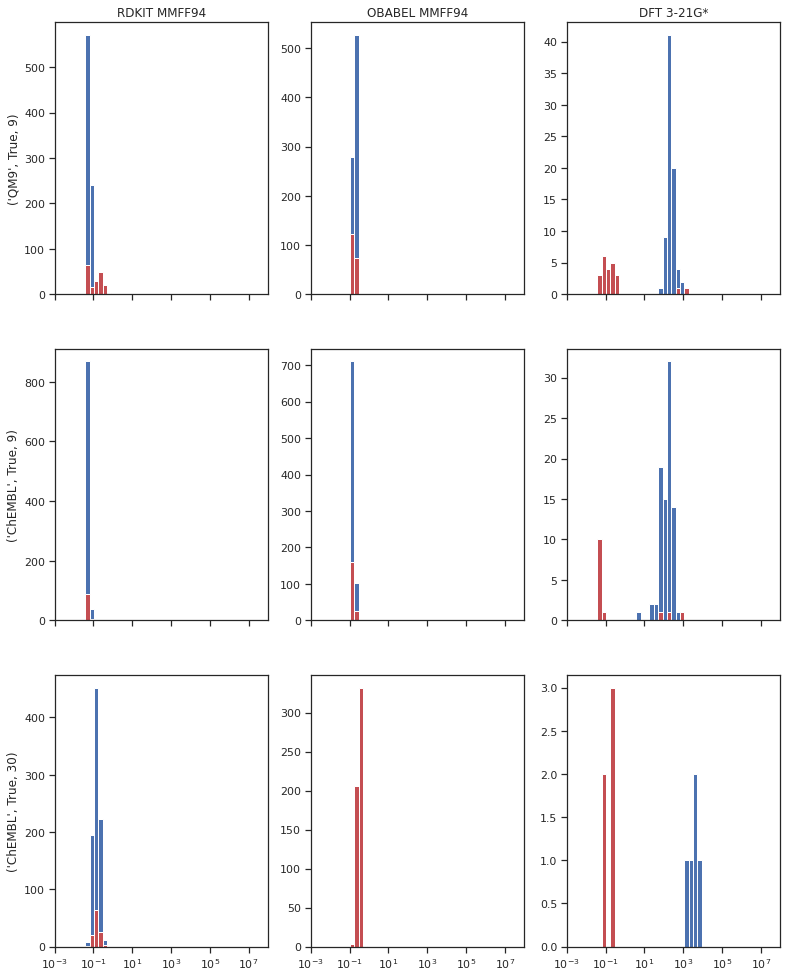

In [14]:
plot_distributions(success_times, failure_times)

In [20]:
from rdkit.Chem.Lipinski import HeavyAtomCount
from rdkit.Chem import MolFromSmiles

def subplot(ax, all_success_smiles, all_success_times):
            
    for i, k in enumerate(keys):

        curr_smi_list = all_success_smiles[k]
        curr_times = all_success_times[k]
    
        # Computing mol sizes
        mol_sizes = [HeavyAtomCount(MolFromSmiles(smi)) for smi in curr_smi_list]
        
        ax.scatter(mol_sizes, curr_times, color=sns.color_palette()[i], label=k)

        
def label_transform(k):
    if k == "RDKIT MMFF94":
        return "MM RDKit"
    elif k == "OBABEL MMFF94":
        return "MM Obabel"
    else:
        return k
        
def plot_size_time(all_success_smiles_CNOF, all_success_times_CNOF, all_success_smiles_all, 
                   all_success_times_all):
    
    
    plt.figure(figsize=(7, 4))
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("Taille en nombre d'électrons")
    plt.ylabel("Temps (s)")
#     plt.ylim((1e-1,1))
    
    for i, k in enumerate(keys):

        curr_smi_list = all_success_smiles_CNOF[k]
        curr_times = all_success_times_CNOF[k]
    
        # Computing mol sizes
#         mol_sizes = [HeavyAtomCount(MolFromSmiles(smi)) for smi in curr_smi_list]
        
        mol_sizes = []
        for smi in curr_smi_list:
            curr_mol_electrons = 0
            mol = MolFromSmiles(smi)
            for atom in mol.GetAtoms():
                curr_mol_electrons += atom.GetAtomicNum()
            mol_sizes.append(curr_mol_electrons)
            
#             if k == "DFT 3-21G*":
#                 print(smi +  " " + str(len(mol.GetAtoms())) + " " + str(curr_mol_electrons))
    
    
        plt.scatter(mol_sizes, curr_times, color=sns.color_palette()[i], label=label_transform(k))
#     plt.legend(loc=(1.01,0.695))
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(fig_path, dpi=200)

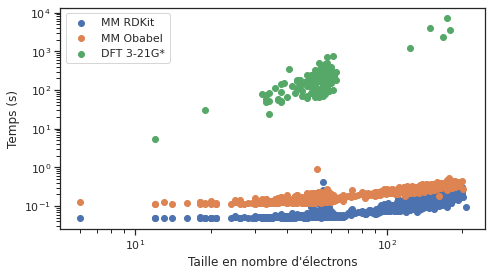

In [21]:
plot_size_time(all_success_smiles_CNOF, all_success_times_CNOF, all_success_smiles_all, all_success_times_all)

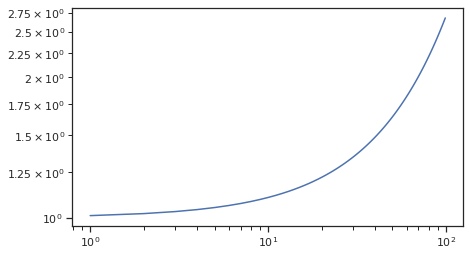

In [26]:
plt.figure(figsize=(7, 4))
plt.yscale("log")
plt.xscale("log")
# plt.plot(np.arange(1, 100), 1.01**np.arange(1, 100))
# plt.plot(np.arange(1, 100), 0.99**np.arange(1, 100))
# plt.plot(np.arange(1, 100), np.arange(1, 100)**4)


In [18]:
from rdkit.Chem.Lipinski import HeavyAtomCount
from rdkit.Chem import MolFromSmiles
        
def label_transform(k):
    if k == "RDKIT MMFF94":
        return "MM RDKit"
    elif k == "OBABEL MMFF94":
        return "MM Obabel"
    else:
        return k
        
def plot_at_size(all_success_smiles_CNOF, all_success_times_CNOF, all_success_smiles_all, 
                all_success_times_all):
    
    
    plt.figure(figsize=(7, 4))
    plt.yscale("log")
#     plt.xscale("log")
    plt.xlabel("Taille en nombre d'atomes lourds")
    plt.ylabel("Taille en nombre d'électrons")
#     plt.ylim((1e-1, 1e5))
    
    for i, k in enumerate(keys):

        curr_smi_list = all_success_smiles_CNOF[k]
#         curr_times = all_success_times_CNOF[k]
    
        # Computing mol sizes
        mol_sizes_at = [HeavyAtomCount(MolFromSmiles(smi)) for smi in curr_smi_list]
        
        mol_sizes = []
        for smi in curr_smi_list:
            curr_mol_electrons = 0
            mol = MolFromSmiles(smi)
            for atom in mol.GetAtoms():
                curr_mol_electrons += atom.GetAtomicNum()
            mol_sizes.append(curr_mol_electrons)
    
    
        plt.scatter(mol_sizes_at, mol_sizes, color=sns.color_palette()[i], label=label_transform(k))
#     plt.legend(loc=(1.01,0.695))
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(fig_path_size, dpi=200)

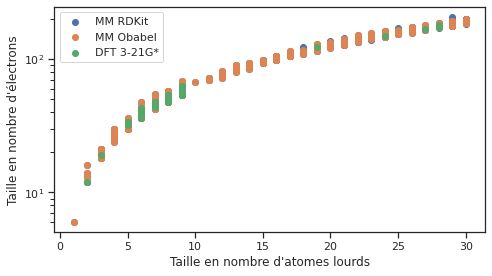

In [19]:
plot_at_size(all_success_smiles_CNOF, all_success_times_CNOF, all_success_smiles_all, all_success_times_all)